# Подготовка прототипа модели для металлообрабатывающего предприятия

## Описание данных

# 1. Подготовка данных

## 1.1. Изучение данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
gold_recovery_train = pd.read_csv('datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('datasets/gold_recovery_full.csv')

In [3]:
print(gold_recovery_train.shape)
gold_recovery_train.head()

In [4]:
print(gold_recovery_test.shape)
gold_recovery_test.head()

In [5]:
print(gold_recovery_full.shape)
gold_recovery_full.head()

In [6]:
# Функция возвращает имя датафрейма
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [7]:
# Функция возвращает информацию по каждому датафрейму из списка.
def pre_check(df_list):
    for df in df_list:
        print('=================================')
        print(get_df_name(df))
        print('_________________________________')
        print(df.info())
        print('Количество дубликатов: ', df.duplicated().sum())
        print('_________________________________')

In [8]:
pre_check([gold_recovery_train])

Дубликатов нет, но во многих столбцах есть пропуски. Все признаки, кроме 'data' принадлежат типу данных `float64`.

Если посмотреть на исходный csv-файл "глазами" в Excel, то можно заметить, что в данных есть не только пропуски, но и ноли, которые тоже можно интерпретировать, как пропущенные значения:
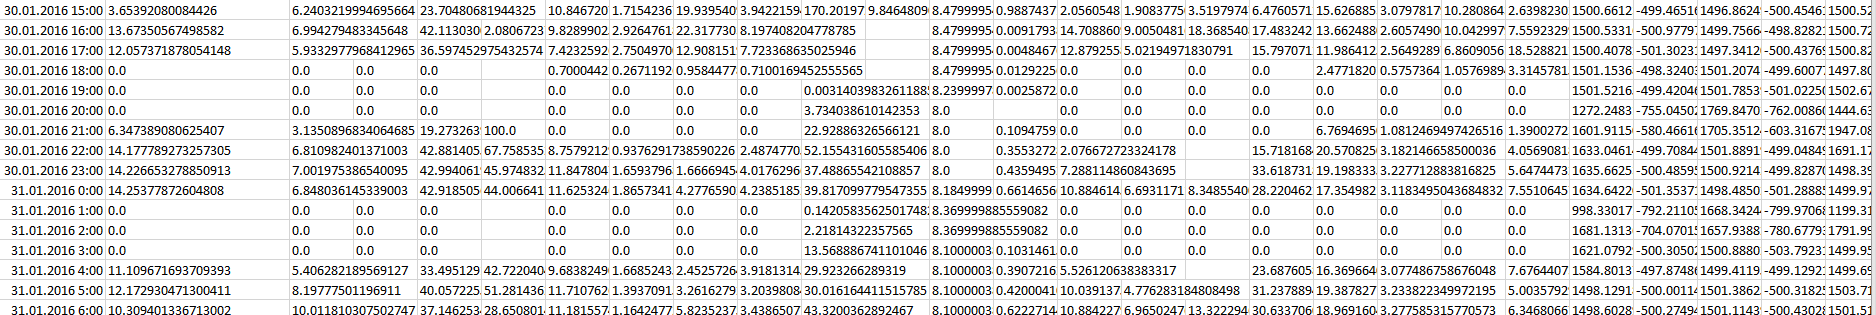

При этом в соседних колонках есть ненулевые значения параметров в то же самое время. Также в некоторых колонках можно заметить несколько одинаковых подряд идущих значений. 

Это можно объяснить следующим образом. Как правило, исторические данные формируются на уровне SCADA-системы и сохраняются в базу данных. Золотодобывающая фабрика представляет собой предприятие со множеством производственных участков, и оборудование на этих участках работает под управлением контроллеров. Значения `0`, несколько подряд идущих одинаковых значений и `NaN` могут объясняться тем, что на уровне АСУТП возникли проблемы с получением данных от датчиков. В контроллерах есть соответствующая настройка, что делать в таком случае. Они могут выдавать на верхний уровень либо `0`, либо последнее значение. `NaN` как правило возникают, если была какая-то проблема с самим контроллером, либо с сервером сбора данных - в этом случае SCADA запишет в хранилище пустые значения. При нормальной работе ровно нулевые значения технологических параметров встречаются редко.

Расчётные значения, полученные по отсутствующим значениям также будут неверны. Но их тоже можно интерполировать.

In [9]:
gold_recovery_train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace=True)
gold_recovery_full.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace=True)

In [10]:
initial_ROUGHER_output_train = gold_recovery_train['rougher.output.recovery']
initial_FINAL_output_train  = gold_recovery_train['final.output.recovery']
initial_ROUGHER_output_full = gold_recovery_full['rougher.output.recovery']
initial_FINAL_output_full  = gold_recovery_full['final.output.recovery']

Напишем функцию, которая сначала заменит в датафрейме значения `0` на `NaN`, а затем интерполирует пропущенные значения. Мы можем это сделать, так как соседние по времени значения часто похожи.

In [11]:
def nan_interpolate(df):
    #df = df.replace(0, np.nan)
    df = df.interpolate()
    return df

In [12]:
gold_recovery_train = nan_interpolate(gold_recovery_train)
gold_recovery_test = nan_interpolate(gold_recovery_test)
gold_recovery_full = nan_interpolate(gold_recovery_full)

Посмотрим, что получилось:

In [13]:
pre_check([gold_recovery_train])

Итак, все пропуски заполнены при помощи интерполяции.

Посмотрим, какие признаки есть в обучающем наборе, а какие - в тестовом.

In [14]:
train_columns = pd.DataFrame(data=gold_recovery_train.columns, columns=['columns'])
print(train_columns.head(60))
print(train_columns.tail(27))

In [15]:
test_features_columns = pd.DataFrame(data=gold_recovery_test.columns, columns=['columns'])
test_features_columns['columns']

В тестовом наборе данных нет признаков с типами параметра `output`, `calculation`. Их нельзя будет использовать при обучении модели.

## 1.2. Проверка расчёта эффективности

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`. Найдём MAE между нашими расчётами и значением признака.

Эффективность обогащения рассчитывается по формуле
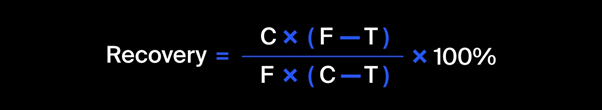
где:

    •	C — доля золота в концентрате после флотации/очистки
    ('rougher.output.concentrate_au');
    •	F — доля золота в сырье/концентрате до флотации/очистки
    ('rougher.input.feed_au');
    •	T — доля золота в отвальных хвостах после флотации/очистки
    ('rougher.output.tail_au').
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.


Напишем функцию для вычисления эффективности обогащения:

In [16]:
def recovery(c,f,t):
    recovery = c*(f-t)/(f*(c-t))*100
    return(recovery)

**Вычислим эффективность обогащения чернового концентрата:**

In [17]:
gold_recovery_train['my_rougher.output.recovery'] = \
recovery(gold_recovery_train['rougher.output.concentrate_au'],
         gold_recovery_train['rougher.input.feed_au'],
         gold_recovery_train['rougher.output.tail_au'])

In [18]:
# Функция для сравнения двух численных колонок датафрейма
def num_columns_compare(df, column1, column2, decimal_place):
    result_array = np.where(df[column1].round(decimal_place) == df[column2].round(decimal_place), True, False)
    result_series = pd.Series(result_array)
    return result_series

Сравним две колонки датафрейма:

In [19]:
num_columns_compare(gold_recovery_train, 'my_rougher.output.recovery', 'rougher.output.recovery', 2).value_counts()

Посчитаем MAE:

In [20]:
mean_absolute_error(initial_ROUGHER_output_train, 
                    gold_recovery_train['my_rougher.output.recovery'])

Будем считать правильной эффективностью обогащения чернового концентрата рассчитанную нами, то есть `my_rougher.output.recovery`.

Так как точно такие же проблемы есть и с колонкой `final.output.recovery`, то для нее мы тоже должны вычислить расчётное значение.

**Вычислим эффективность обогащения финального концентрата:**

In [21]:
gold_recovery_train['my_final.output.recovery'] = \
recovery(gold_recovery_train['final.output.concentrate_au'],
         gold_recovery_train['rougher.input.feed_au'],
         gold_recovery_train['final.output.tail_au'])

In [22]:
num_columns_compare(gold_recovery_train, 'my_final.output.recovery', 'final.output.recovery', 2).value_counts()

Посчитаем MAE:

In [23]:
mean_absolute_error(initial_FINAL_output_train, 
                    gold_recovery_train['my_final.output.recovery'])

Будем считать правильной эффективностью обогащения финального концентрата рассчитанную нами, то есть `my_final.output.recovery`.

Вычислим эти же признаки для gold_recovery_full:

In [24]:
gold_recovery_full['my_rougher.output.recovery'] = \
recovery(gold_recovery_full['rougher.output.concentrate_au'],
         gold_recovery_full['rougher.input.feed_au'],
         gold_recovery_full['rougher.output.tail_au'])

In [25]:
gold_recovery_full['my_final.output.recovery'] = \
recovery(gold_recovery_full['final.output.concentrate_au'],
         gold_recovery_full['rougher.input.feed_au'],
         gold_recovery_full['final.output.tail_au'])

# 2. Анализ данных

In [26]:
gold_recovery_train[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]

In [27]:
gold_recovery_train[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]

In [28]:
gold_recovery_train[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

In [29]:
# Функция для вычисления перцентиля
def get_percentile(df, column_name, percentile_rank):
    
    # Удалим NaN в столбце, отсортируем df, сбросим индексы
    try:
        # Если на входе - dataframe
        df = df.dropna(subset=[column_name]).sort_values(by=column_name).reset_index()
    except:
        # Если на входе - series
        df = df.dropna().sort_values().reset_index()
    # Найдём индекс перцентиля
    index = (len(df.index)-1) * percentile_rank / 100.0
    index = int(index)
    value = df.at[index, column_name]
    # Вернём элемент с этим индексом
    return value

In [30]:
# Функция для вычисления интерквартильного размаха.
def interquartile_range(df, column_name):
    
    p75 = get_percentile(df, column_name, 75)  # 75-й перцентиль
    p25 = get_percentile(df, column_name, 25)  # 25-й перцентиль
    iqr = p75 - p25  # интерквартильный размах
    return iqr

In [31]:
# Функция для вычисления левого уса.
def left_mustache(df, column_name):
    p25 = get_percentile(df, column_name, 25)
    iqr = interquartile_range(df, column_name)
    p0 = get_percentile(df, column_name, 0)
    if p25 - iqr*1.5 < p0:
        return (p0)
    return(p25 - iqr*1.5)

In [32]:
# Функция для вычисления правого уса
def right_mustache(df, column_name):
    p75 = get_percentile(df, column_name, 75)
    iqr = interquartile_range(df, column_name)
    p100 = get_percentile(df, column_name, 100)
    if p75 + iqr*1.5 > p100:
        return (p100)
    return(p75 + iqr*1.5)

In [33]:
# Функция для построения гистограммы по значениям, входящим в ящик с усами.
def box_mustache_hist(df, column_name, bins, color, title=False, density=False):
    
    # Отсортируем df, сбросим индексы
    df = df.sort_values(by=column_name).reset_index()
    split = df.loc[(df.loc[:, column_name] >= left_mustache(df, column_name))\
                  &(df.loc[:, column_name] <= right_mustache(df, column_name))][column_name]
    #plt.figure(figsize=(9,5))
    plt.hist(split, bins=bins, alpha=0.7, label=column_name, density=density)
    plt.legend(loc='upper left')
    if title == False:
        plt.title(column_name)
    else:
        plt.title(title)
    # Вертикальные линии для каждого перцентиля
    plt.axvline(get_percentile(df, column_name, 25), linestyle='--', color=color)
    plt.axvline(get_percentile(df, column_name, 50), linestyle='-',  color=color)
    plt.axvline(get_percentile(df, column_name, 75), linestyle='--', color=color)
    #plt.show()
    print('_______________')
    print('Параметр: ', column_name)
    print('Среднее значение: ', round(df[column_name].mean(),2))
    print('Стандартное отклонение: ', round(df[column_name].std(),2))
    print('Медиана: ', get_percentile(df, column_name, 50))

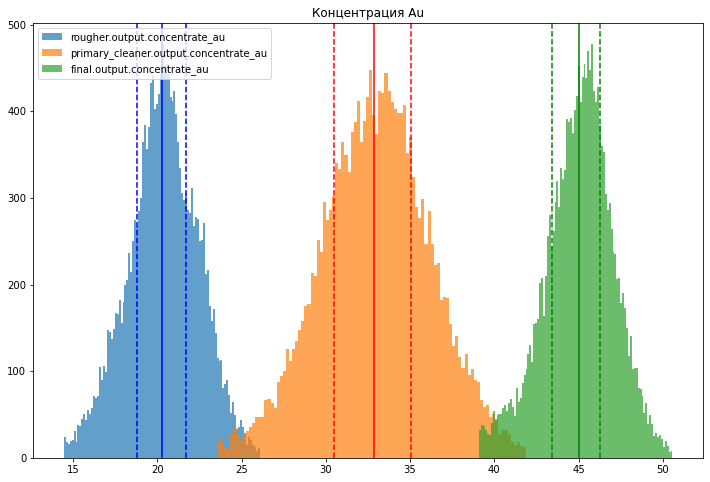

In [34]:
plt.figure(figsize=(12,8))
           
box_mustache_hist(gold_recovery_full, 'rougher.output.concentrate_au', 
                  100, 'blue')
box_mustache_hist(gold_recovery_full, 'primary_cleaner.output.concentrate_au', 
                  100, 'red')
box_mustache_hist(gold_recovery_full, 'final.output.concentrate_au', 
                  100,'green', title='Концентрация Au')

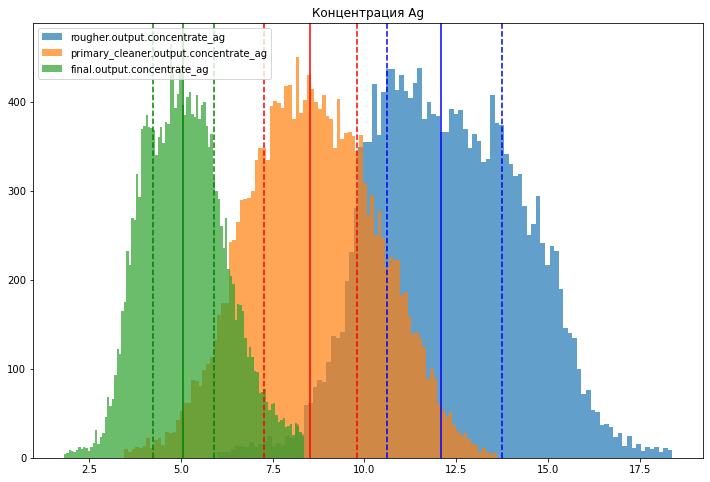

In [35]:
plt.figure(figsize=(12,8))
           
box_mustache_hist(gold_recovery_full, 'rougher.output.concentrate_ag', 100, 'blue')
box_mustache_hist(gold_recovery_full, 'primary_cleaner.output.concentrate_ag', 100, 'red')
box_mustache_hist(gold_recovery_full, 'final.output.concentrate_ag', 100, 'green', title='Концентрация Ag')

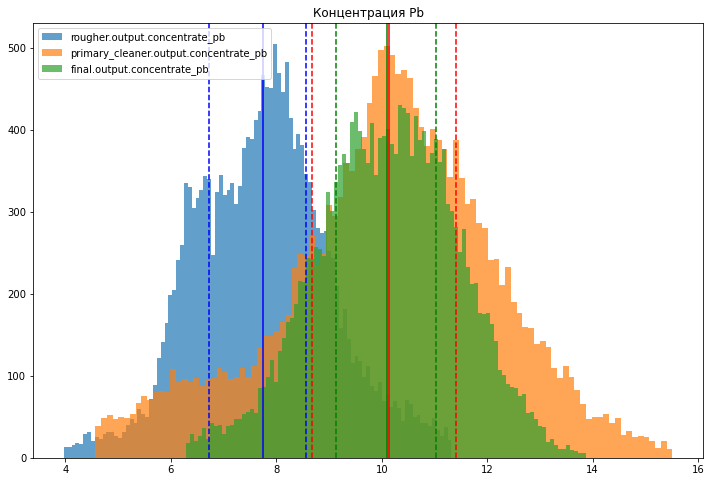

In [36]:
plt.figure(figsize=(12,8))
           
box_mustache_hist(gold_recovery_full, 'rougher.output.concentrate_pb', 100, 'blue')
box_mustache_hist(gold_recovery_full, 'primary_cleaner.output.concentrate_pb', 100, 'red')
box_mustache_hist(gold_recovery_full, 'final.output.concentrate_pb', 100, 'green', title='Концентрация Pb')

**Выводы:**

- Концентрация золота увеличивается с каждым этапом. Об этом свидетельствует увеличение средних значений. А стандартное отклонение уменьшается.
- Концентрация серебра уменьшается от этапа к этапу.
- Концентрация свинца судя по средним значениям увеличивается от флотации к первичной очистке, а затем немного уменьшается на выходе.

Сравним распределение гранул сырья на обучающей и тестовой выборках.

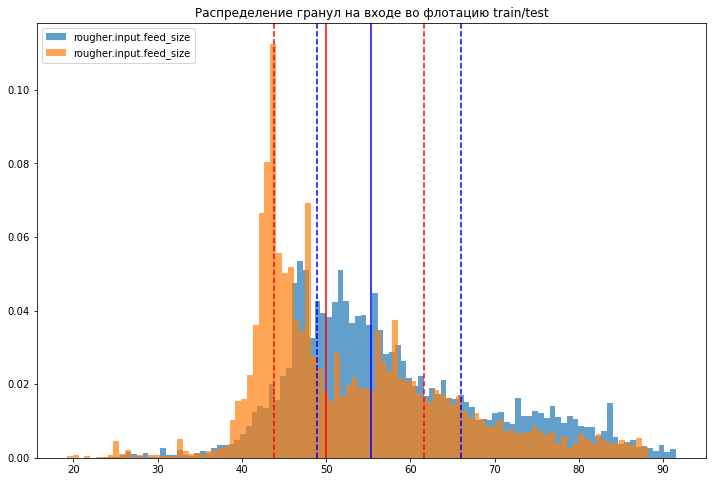

In [37]:
plt.figure(figsize=(12,8))
           
box_mustache_hist(gold_recovery_train, 'rougher.input.feed_size', 100, 'blue', title=False, density=True)
box_mustache_hist(gold_recovery_test, 'rougher.input.feed_size', 100, 'red', 
                  title='Распределение гранул на входе во флотацию train/test', density=True)

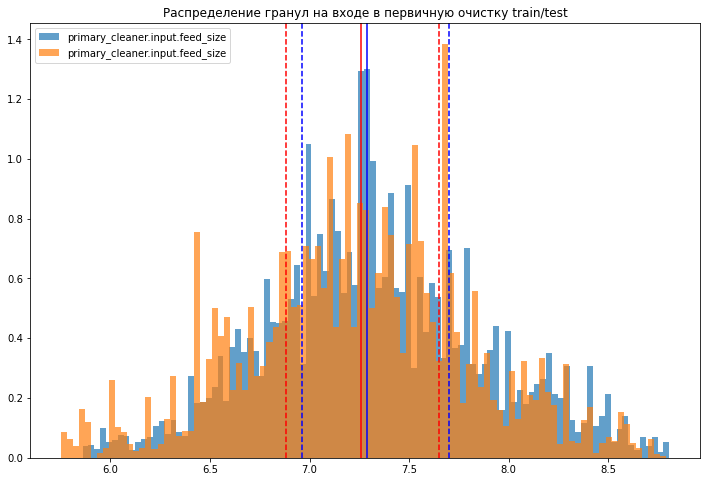

In [38]:
plt.figure(figsize=(12,8))
           
box_mustache_hist(gold_recovery_train, 'primary_cleaner.input.feed_size', 100, 'blue', title=False, density=True)
box_mustache_hist(gold_recovery_test, 'primary_cleaner.input.feed_size', 100, 'red', 
                  title='Распределение гранул на входе в первичную очистку train/test', density=True)

**Вывод:**

Распределения размеров гранул сырья на обучающей выборке и на тестовой не сильно различаются. 

Сравним также целевые значения эффективности обогащения чернового концентрата и финального концентрата.

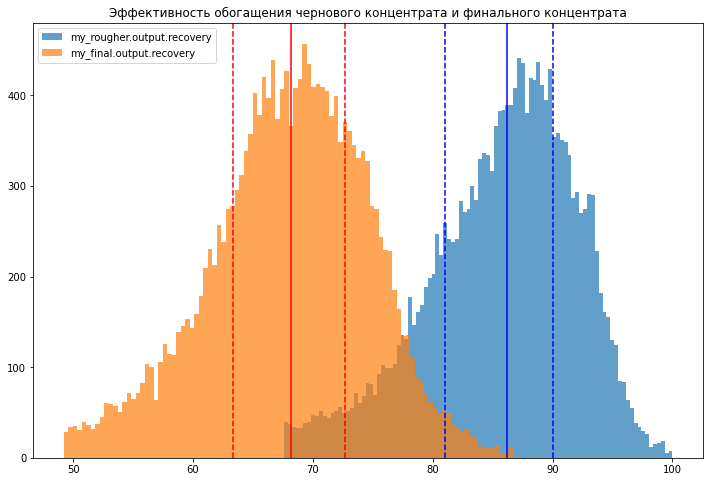

In [39]:
plt.figure(figsize=(12,8))
           
box_mustache_hist(gold_recovery_full, 'my_rougher.output.recovery', 100, 'blue', title=False)
box_mustache_hist(gold_recovery_full, 'my_final.output.recovery', 100, 'red', title=
                 'Эффективность обогащения чернового концентрата и финального концентрата')

Эффективность обогащения финального концентрата меньше эффективности обогащения чернового концентрата. Видимо поэтому при расчёте итогового sMAPE первому придан в 3 раза больший вес.


    
Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Построим два графика: один - нашей функцией `box_mustache_hist()`, которая убирает выбросы, а второй - функцией `hist()`, и сравним их.


In [40]:
gold_recovery_train['rougher_output_concentrate_sum'] = gold_recovery_full['rougher.output.concentrate_au'] +\
gold_recovery_train['rougher.output.concentrate_ag'] +\
gold_recovery_train['rougher.output.concentrate_pb'] +\
gold_recovery_train['rougher.output.concentrate_sol']

gold_recovery_train['primary_cleaner_output_concentrate_sum'] = gold_recovery_full['primary_cleaner.output.concentrate_au'] +\
gold_recovery_train['primary_cleaner.output.concentrate_ag'] +\
gold_recovery_train['primary_cleaner.output.concentrate_pb'] +\
gold_recovery_train['primary_cleaner.output.concentrate_sol']

gold_recovery_train['final_output_concentrate_sum'] = gold_recovery_full['final.output.concentrate_au'] +\
gold_recovery_train['final.output.concentrate_ag'] +\
gold_recovery_train['final.output.concentrate_pb'] +\
gold_recovery_train['final.output.concentrate_sol']


In [41]:
gold_recovery_train.shape

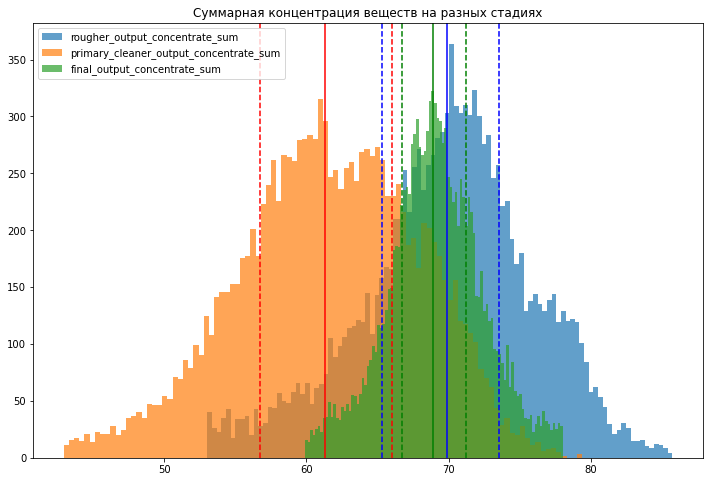

In [42]:
plt.figure(figsize=(12,8))

good_indexes_1 = box_mustache_hist(gold_recovery_train, 'rougher_output_concentrate_sum', 100, 'blue') 
box_mustache_hist(gold_recovery_train, 'primary_cleaner_output_concentrate_sum', 100, 'red')           
box_mustache_hist(gold_recovery_train, 'final_output_concentrate_sum', 100, 'green', title=
                  'Суммарная концентрация веществ на разных стадиях')


In [43]:
#gold_recovery_full.query('rougher_output_concentrate_sum not in @good_indexes_1.index')


Теперь график по всем значениям:

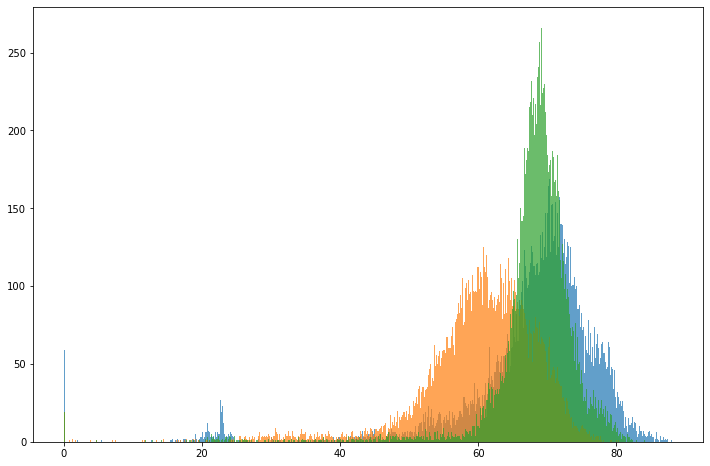

In [44]:
plt.figure(figsize=(12,8))

plt.hist(gold_recovery_train['rougher_output_concentrate_sum'], bins=600, alpha=0.7)
plt.hist(gold_recovery_train['primary_cleaner_output_concentrate_sum'], bins=600, alpha=0.7)
plt.hist(gold_recovery_train['final_output_concentrate_sum'], bins=600, alpha=0.7)
plt.show()

Налицо выбросы. Избавимся от них:

In [45]:
gold_recovery_train = gold_recovery_train[(gold_recovery_train['rougher_output_concentrate_sum'] > 40) &\
                   (gold_recovery_train['primary_cleaner_output_concentrate_sum'] > 40) &\
                   (gold_recovery_train['final_output_concentrate_sum'] > 40)]

Мы удалили выбросы и сохранили финальную выборку для обучения модели.

# 3. Построение модели

Напишем функцию для вычисления sMAPE (Symmetric mean absolute percentage error).
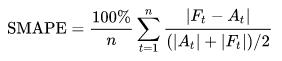

У этой метрики диапазон значений от 0% до 200%.

In [47]:
# Функция для расчёта sMAPE
def smape(A, F):
    """ 
    А - actual value (значение целевого признака для объекта с порядковым номером t в выборке, 
    на которой измеряется качество)
    F - forcast value (значение предсказания для объекта с порядковым номером t, 
    например, в тестовой выборке)
    n - количество объектов в выборке
    """
    return (100/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [48]:
def smape_final(smape_rougher, smape_final):
    print("Итоговая sMAPE: {:.2f}".format(np.abs(0.25*smape_rougher + 0.75*smape_final)), "%")

Для вычисления sMAPE(rougher) возьмём те признаки, которые относятся к флотации.

In [49]:
FEATURES_LIST1 = test_features_columns.loc[13:34]['columns']
FEATURES_LIST1

Для вычисления sMAPE(final) возьмём те признаки, которые относятся к очистке.

In [50]:
FEATURES_LIST2 = test_features_columns.query('columns not in @FEATURES_LIST1').drop(0)['columns']
FEATURES_LIST2

In [51]:
# Функция возвращает features и target для датафрейма
def xy_prepare(df, features_list, target_name):
    features = df[features_list]
    target = df[target_name]
    return features, target

In [52]:
# Функция возвращает предсказания лучшей модели и target_valid
def best_model(df_train, 
                  features_list, 
                  target_name,
                  model,
                  param_grid, 
                  cv, 
                  refit):
    # Разбиваем датафрейм на features/target
    features_train, target_train = xy_prepare(df_train, features_list, target_name)
    # Масштабируем признаки
    #pd.options.mode.chained_assignment = None
    #scaler = StandardScaler()
    #scaler.fit(features_train)
    #features_train.loc[:,features_list] = scaler.transform(features_train.loc[:,features_list])
    
    my_scorer = {'SMAPE': make_scorer(smape, greater_is_better=False),
                'MAE': make_scorer(mean_absolute_error)}
    
    model = model
    grid = GridSearchCV(model, 
                        param_grid, 
                        cv=cv, 
                        #verbose = 3, 
                        refit=refit, 
                        scoring=my_scorer) 
    grid_result = grid.fit(features_train, target_train)
    best_model = grid_result.best_estimator_
    best_score = grid_result.best_score_
    best_params = grid.best_params_
    print(best_params)
    print(refit, ": {:.2f}".format(best_score), "%")
    return(best_model, best_score)

**Линейная регрессия**

____________________________

In [53]:
# Сетка параметров для линейной регрессии
PARAM_GRID_LR = {'fit_intercept': [False, True],
              'normalize': [False, True],
             'n_jobs': [-1, None]}  
PARAM_GRID_LR

In [54]:
model_LR_r, smape_LR_r = best_model(gold_recovery_train, 
                       FEATURES_LIST1, 
                       'my_rougher.output.recovery', 
                       LinearRegression(),
                       PARAM_GRID_LR, 
                       5, 
                       'SMAPE')

In [55]:
model_LR_f, smape_LR_f = best_model(gold_recovery_train, 
                       FEATURES_LIST2, 
                       'my_final.output.recovery', 
                       LinearRegression(),
                       PARAM_GRID_LR, 
                       5, 
                       'SMAPE')

In [56]:
smape_final(smape_LR_r, smape_LR_f)

______________________

**Дерево решений. Регрессия**
_____________________

In [57]:
# Сетка параметров для DecisionTreeRegressor()
PARAM_GRID_DTR = {'splitter': ['best', 'random'],
                  'max_depth': range(1,10),
                  'min_samples_leaf': range(1,5),
                 'random_state': [12345]}  
PARAM_GRID_DTR

In [58]:
%%time
model_DTR_r, smape_DTR_r = best_model(gold_recovery_train, 
                       FEATURES_LIST1, 
                       'my_rougher.output.recovery', 
                       DecisionTreeRegressor(),
                       PARAM_GRID_DTR, 
                       5, 
                       'SMAPE')

In [59]:
%%time
model_DTR_f, smape_DTR_f = best_model(gold_recovery_train, 
                       FEATURES_LIST2, 
                       'my_final.output.recovery', 
                       DecisionTreeRegressor(),
                       PARAM_GRID_DTR, 
                       5, 
                       'SMAPE')

In [60]:
smape_final(smape_DTR_r, smape_DTR_f)

______________________

**Случайный лес. Регрессия**
__________

In [61]:
# Сетка параметров для RandomForestRegressor()
PARAM_GRID_RFR = {'n_estimators': [3,  10,  31, 100], #np.logspace(0, 2, 5, endpoint=True, dtype = 'int')
                  'max_depth': range(1,5),
                  #'min_samples_leaf': range(1,5),
                 'random_state': [12345]}  
PARAM_GRID_RFR

In [62]:
%%time
model_RFR_r, smape_RFR_r = best_model(gold_recovery_train, 
                       FEATURES_LIST1, 
                       'my_rougher.output.recovery', 
                       RandomForestRegressor(),
                       PARAM_GRID_RFR, 
                       5, 
                       'SMAPE')

In [63]:
%%time
model_RFR_f, smape_RFR_f = best_model(gold_recovery_train, 
                       FEATURES_LIST2, 
                       'my_final.output.recovery', 
                       RandomForestRegressor(),
                       PARAM_GRID_RFR, 
                       5, 
                       'SMAPE')

In [64]:
smape_final(smape_RFR_r, smape_RFR_f)

______________________

# Проверка на тестовой выборке

Лучшие результаты (кроме времени) показала модель случайного леса.

Признаки для *rougher* и *final* соответственно:

In [65]:
features1_test = gold_recovery_test[FEATURES_LIST1]
features2_test = gold_recovery_test[FEATURES_LIST2]

In [66]:
targets_test = gold_recovery_full.query('date in @gold_recovery_test.date')[['date', 
                                                                             'my_rougher.output.recovery', 
                                                                             'my_final.output.recovery']]\
.reset_index(drop=True)

Цели для *rougher* и *final* соответственно:

In [67]:
target1_test = targets_test['my_rougher.output.recovery']
target2_test = targets_test['my_final.output.recovery']

Предсказания модели для *rougher* и *final* соответственно:

In [68]:
predictions1_test = pd.Series(model_RFR_r.predict(gold_recovery_test[FEATURES_LIST1]), 
                              index=gold_recovery_test[FEATURES_LIST1].index)
predictions2_test = pd.Series(model_RFR_f.predict(gold_recovery_test[FEATURES_LIST2]), 
                              index=gold_recovery_test[FEATURES_LIST2].index)

In [69]:
SMAPE_R = smape(target1_test, predictions1_test)
print('SMAPE_R: {:.2F}'.format(SMAPE_R), "%")
SMAPE_F = smape(target2_test, predictions2_test)
print('SMAPE_F: {:.2F}'.format(SMAPE_F), "%")

In [70]:
smape_final(SMAPE_R, SMAPE_F)

# Выводы

Построена модель, предсказывающая коэффициент восстановления золота из золотосодержащей руды. Проанализированы данные с параметрами добычи и очистки.
Построена и обучена модель, помогающая оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

- Анализ данных показал, что концентрация золота от первой стадии к финальной увеличивается.
- Концентрация серебра от первой стадии к финальной уменьшается.
- На разных стадиях в суммарной концентрации веществ были найдены выбросы и удалены из обучающей выборки.
- Итоговый sMAPE лучший для модели случайного леса.